# Load numpy and all other packages required

In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


# Parameters

In [57]:
NoParticles = 1000;       # Number of particles in the system
xsize = 512;            # Pixel size of the binary image in the x direction, no should be even
ysize = 512;            # Pixel size of the binary image in the y direction, no should be even  
Binaryframewidth = 100;  # Frame around binary image without any cells
dt = 2;                  # Time step of the displacement
Particleradius = 5;      # Radius of the particles in the binary image before Gaussian Blurring and noise addition
Gaussianwidth = 3;       # Standard deviation for Gaussian kernel in px
Noise_std = 70;          # Standard deviation of the noise
width = 100
Elasticity = 10000;      # Youngs modulus
Poisson = 0.3;             # Poisson ratio
um_px = 0.1;
N_forces = 5;
Force_dist = 10;
Force_Strength = 5000;


# Create particles
Here, we generate N particles randomly and homogeneously distributed in the 2d space.

In [58]:
import numpy as np
Particles_Pos = np.random.rand(NoParticles,2)
Particles_Pos[:, 0] = (Particles_Pos[:,0] -0.5) * (xsize - width) * um_px 
Particles_Pos[:, 1] = (Particles_Pos[:,1] -0.5) * (ysize - width) * um_px

# Generate force field
Here, I create a list of points where forces act and the force vectors

In [59]:
angles = np.arange(0,1,1/N_forces)*2*np.pi
force_x = Force_dist * np.cos(angles)
force_y = Force_dist * np.sin(angles)
force_fx = - Force_Strength * np.cos(angles);
force_fy = - Force_Strength * np.sin(angles);
    

# Plot force field

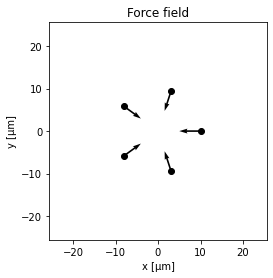

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.quiver(force_x,force_y,force_fx,force_fy, angles='xy', scale_units='xy', scale=1000)
plt.plot(force_x, force_y, 'o', color='black');
ax.set_aspect('equal')
plt.xlim([-xsize/2*um_px, xsize/2*um_px])
plt.ylim([-ysize/2*um_px, ysize/2*um_px])
plt.title("Force field")
plt.xlabel("x [µm]")
plt.ylabel("y [µm]")
plt.savefig('ForceField.png', dpi=300)

# Calculate displacement field at specific location
This is based on the Landau-Lifschitz book on Elasticity (Eq. 8.14) and the Bousseinesq-Green function. Also check the paper from Huang et al., Sabass 2019.

In [61]:
# Given location x,y. This location is not allowed to be where the force point sources are located. 
def dispx(x, y):
    ux = 0;
    for i in range(N_forces):
        r = np.sqrt((x - force_x[i])**2 + (y - force_y[i])**2);
        uxx_add = (1+Poisson) / (np.pi * Elasticity) * ((1 - Poisson)/r + Poisson / (r**3) * (x - force_x[i]) * (x - force_x[i])) * force_fx[i]
        uxy_add = (1+Poisson) / (np.pi * Elasticity) * (                  Poisson / (r**3) * (x - force_x[i]) * (y - force_y[i])) * force_fy[i]
        ux = ux + uxx_add + uxy_add
    return ux

def dispy(x, y):
    uy = 0;
    for i in range(N_forces):
        r = np.sqrt((x - force_x[i])**2 + (y - force_y[i])**2);
        uyy_add = (1+Poisson) / (np.pi * Elasticity) * ((1 - Poisson)/r + Poisson / (r**3) * (y - force_y[i]) * (y - force_y[i])) * force_fy[i]
        uyx_add = (1+Poisson) / (np.pi * Elasticity) * (                  Poisson / (r**3) * (y - force_y[i]) * (x - force_x[i])) * force_fx[i]
        uy = uy + uyx_add +uyy_add
    return uy

# Plot displacement field
Right now I use a field that attracts the cells to the point (0,0) with the potential V ~ x^2 + y^2. Change vx and vy for other types of displacements, for example rotation around (0,0).

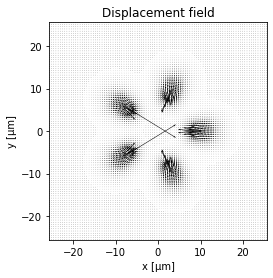

In [63]:
import matplotlib.pyplot as plt
x,y = np.meshgrid(np.linspace(-xsize/2*um_px,xsize/2*um_px,100),np.linspace(-ysize/2*um_px,ysize/2*um_px,100))
dx = dispx(x,y);
dy = dispy(x,y);
fig = plt.figure()
ax = fig.add_subplot(111)
plt.quiver(x,y,dx,dy, angles='xy', scale_units='xy', scale=0.1)
ax.set_aspect('equal')
plt.xlim([-xsize/2*um_px, xsize/2*um_px])
plt.ylim([-ysize/2*um_px, ysize/2*um_px])
plt.title("Displacement field")
plt.xlabel("x [µm]")
plt.ylabel("y [µm]")
plt.savefig('DisplacementField.png', dpi=300)

# Displace particles
Here, we displace the cells with the velocity fields vx and vy.

In [64]:
#def velocityx(x, y):
#  return -(5 * 2 / xsize) * x; # Alternatively one can use (20 * 2 / xsize) * y
#def velocityy(x, y):
#  return -(5 * 2 / ysize) * y; # Alternatively one can use -(20 * 2 / ysize) * x

import numpy as np
import matplotlib.pyplot as plt
# Displacements
dx = dispx(Particles_Pos[:,0], Particles_Pos[:,1])
dy = dispy(Particles_Pos[:,0], Particles_Pos[:,1])
# Apply velocity fields to particles
New_Particles_Pos = Particles_Pos * 0;
New_Particles_Pos[:,0] = Particles_Pos[:,0] + dx
New_Particles_Pos[:,1] = Particles_Pos[:,1] + dy

# Figure particles before and after
Here, we create a image of the particles before (red) and after the particles are displaced by the velocity field.

In [28]:
#part_pos2 = np.random.rand(NoParticles,2)
#part_pos2[:, 0] = (part_pos2[:,0] -0.5) * (xsize) 
#part_pos2[:, 1] = (part_pos2[:,1] -0.5) * (ysize)
#x = part_pos2
# print(x)
#print(x.shape)
#x1 = np.take(x, np.where(x<-width*2)[0], axis=0)
#x2 = np.take(x, np.where(x>width*2)[0], axis=0)
#part_pos2 = np.concatenate([x1,x2])
# part_pos2

(-25.6, 25.6)

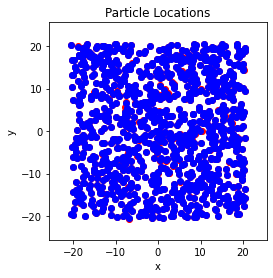

In [65]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(Particles_Pos[:,0], Particles_Pos[:,1], c='r')
plt.scatter(New_Particles_Pos[:,0], New_Particles_Pos[:,1], c='b')
#plt.scatter(part_pos2[:,0], part_pos2[:,1], c='green')
plt.title("Particle Locations")
plt.xlabel("x")
plt.ylabel("y")
ax.set_aspect('equal')
plt.xlim([-xsize/2*um_px, xsize/2*um_px])
plt.ylim([-ysize/2*um_px, ysize/2*um_px])

# Create binary images before and after velocity field applied
Here, we initialize the zero arrays of size (xsize, ysize). Then, we find those pixel that are within a circle of radius "Particleradius", iterate over all particles and add the value 255 into those pixel within the circle.

In [66]:
# Import
import matplotlib.pyplot as plt
from skimage import draw
# Initialise Arrays
Binary      = np.zeros((xsize,ysize), dtype=np.int) 
New_Binary  = np.zeros((xsize,ysize), dtype=np.int) 
# Prepare index array
y, x = np.ogrid[-Particleradius: Particleradius, -Particleradius: Particleradius]
index = x**2 + y**2 <= Particleradius**2
# Add particles to array for the initial binary image
for j in range(0, NoParticles):
    Centerx = int(Particles_Pos[j,0]/um_px+xsize/2)
    Centery = int(Particles_Pos[j,1]/um_px+ysize/2)
    Binary[Centery-Particleradius:Centery+Particleradius, Centerx-Particleradius:Centerx+Particleradius][index] = 255
# Add particles to array for the initial binary image
for j in range(0, NoParticles):
    Centerx = int(New_Particles_Pos[j,0]/um_px+xsize/2)
    Centery = int(New_Particles_Pos[j,1]/um_px+ysize/2)
    New_Binary[Centery-Particleradius:Centery+Particleradius, Centerx-Particleradius:Centerx+Particleradius][index] = 255




# Add a random drift


In [71]:
#dx = np.random.randint(1,10)
#dy = np.random.randint(1,10)

#Binary = Binary[dy:ysize+dy, dx:xsize+dx]
#New_Binary = New_Binary[dy:ysize+dy, dx:xsize+dx]

#print(Binary.shape, New_Binary.shape)

#cx,cy = cnts['x'], cnts['y']
#arr = np.array([cx,cy]).T

#from scipy.spatial import ConvexHull

#hull = ConvexHull(arr)
#print(arr.shape)
#fig = plt.figure()
#ax = fig.add_subplot(111)
#plt.scatter(*arr.T)
#roi = dict(x=[], y=[])
#for simplex in hull.simplices:
#    plt.plot(arr[simplex, 0], arr[simplex, 1], 'k-')
#    roi['x'].append(arr[simplex, 0])
#    roi['y'].append(arr[simplex, 1])

#import math
#pp = list(np.array([np.array(roi['x']).flatten(), np.array(roi['y']).flatten()]).T)
#cent=(sum([p[0] for p in pp])/len(pp),sum([p[1] for p in pp])/len(pp))
#pp.sort(key=lambda p: math.atan2(p[1]-cent[1],p[0]-cent[0]))
#roi = np.array(pp)
#
#roi.shape
#
#ax.set_aspect('equal')
# plt.plot(roi, c='r')

# Gaussian blur images
Here, we Gaussian Blur the images.

In [67]:
from scipy.ndimage.filters import gaussian_filter
Image_old = gaussian_filter(Binary, sigma=Gaussianwidth)
Image_new = gaussian_filter(New_Binary, sigma=Gaussianwidth)

# Add noise on top of binary images
Here, we add White noise on the data.

In [68]:
import random
for i in range(xsize): 
    for j in range(ysize):
        Noise=random.gauss(0, Noise_std)
        Image_old[i,j] = Image_old[i,j] + Noise
        
for i in range(xsize): 
    for j in range(ysize):
        Noise=random.gauss(0, Noise_std)
        Image_new[i,j] = Image_new[i,j] + Noise

# Show binary images before and after
Output the images before and after.

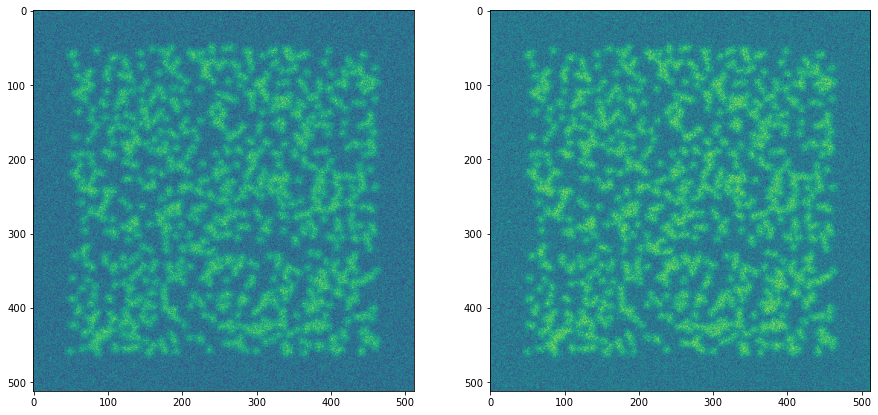

In [69]:
import matplotlib.pyplot as plt
import numpy as np
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(Image_old)
axarr[1].imshow(Image_new)

# Save Images

In [70]:
import cv2
cv2.imwrite('Image_old.tiff',Image_old.astype(int))
cv2.imwrite('Image_new.tiff',Image_new.astype(int))
cv2.imwrite('Ground_old.tiff',Binary.astype(int))
cv2.imwrite('Ground_new.tiff',New_Binary.astype(int))

True

# Save binary images to use them for PIV
Save the images so that they can be used by the TFM pipeline.

In [ ]:
#bead_ref = Image_old

In [ ]:
#bead_i = Image_new

In [ ]:
#img_dummy = np.zeros(bead_ref.shape, dtype=np.int32)

In [ ]:
#img = np.stack([[bead_i, img_dummy]])
#ref = np.stack([bead_ref, img_dummy])

In [ ]:
#Image_old.shape
#Image_new.shape

#stack = np.stack([bead_i, bead_ref])



#from skimage import io
#io.imsave('../data/sim/stack.tif', stack)


# break

In [ ]:
#import numpy as np
#from skimage import io
#import matplotlib.pyplot as plt

#from pytraction import TractionForceConfig
#from pytraction import plot, prcoess_stack

# save images to disk
#io.imsave('../data/sim/tfm.tif', img)
#io.imsave('../data/sim/tfm-ref.tif', ref)

In [ ]:
#pix_per_mu = 1.3 # The number of pixels per micron 
#E = 100 # Youngs modulus in Pa

#img_path = '../data/sim/tfm.tif'
#ref_path = '../data/sim/tfm-ref.tif'

In [ ]:


#traction_config = TractionForceConfig(pix_per_mu, E=E) # config TractionForceConfig object
#img, ref, _ = traction_config.load_data(img_path, ref_path) # we can load the dat using the load_data method


In [ ]:
#x,y = roi.T
plt.plot(x,y, c='r')
plt.imshow(img[0,0,:,:])

In [ ]:
log1 = process_stack(img, ref, traction_config, verbose=1, roi=(x,y))

In [ ]:
# log1?

In [ ]:
for frame in range(len(log1)):
    plot(log1, frame=frame, mask=True)

In [ ]:
log1['stack_bead_roi'][0]
io.imsave('../data/sim/stack.tif', img)

In [ ]:


plt.scatter(x,y)

In [ ]:
isinstance((x,y), tuple)